<a href="https://colab.research.google.com/github/vladgap/Various/blob/main/Backprop_classif_2D_article_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://peterroelants.github.io/posts/neural-network-implementation-part04/

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np  # Matrix and vector computation package
import sklearn
import sklearn.datasets # To generate the dataset
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)
#

In [2]:
# Generate the dataset
X, t = sklearn.datasets.make_circles(
    n_samples=100, shuffle=False, factor=0.3, noise=0.1)
T = np.zeros((100, 2)) # Define target matrix
T[t==1, 1] = 1
T[t==0, 0] = 1
# Separate the red and blue samples for plotting
x_red = X[t==0]
x_blue = X[t==1]

print('shape of X: {}'.format(X.shape))
print('shape of T: {}'.format(T.shape))
#

shape of X: (100, 2)
shape of T: (100, 2)


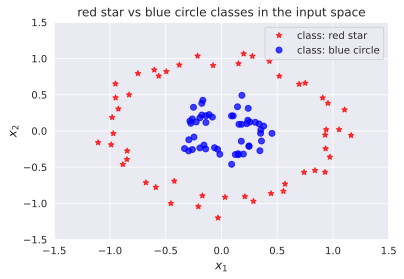

In [3]:
# Plot both classes on the x1, x2 plane
plt.figure(figsize=(6, 4))
plt.plot(x_red[:,0], x_red[:,1], 'r*', 
         label='class: red star', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', 
         label='class: blue circle', alpha=0.75)
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red star vs blue circle classes in the input space')
plt.show()
#

In [4]:
def logistic(z):
    """Logistic function."""
    return 1. / (1. + np.exp(-z))


def softmax(z):
    """Softmax function"""
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)


def hidden_activations(X, Wh, bh):
    """Compute the hidden activations h"""
    return logistic((X @ Wh) + bh)


def output_activations(H, Wo, bo):
    """Compute the output y"""
    return softmax((H @ Wo) + bo)


def nn(X, Wh, bh, Wo, bo):
    """Neural network as function."""
    return output_activations(hidden_activations(X, Wh, bh), Wo, bo)


def nn_predict(X, Wh, bh, Wo, bo):
    """Neural network prediction function that only returns
    1 or 0 depending on the predicted class"""
    return np.around(nn(X, Wh, bh, Wo, bo))

In [5]:
def loss(Y, T):
    """Loss function"""
    return - (T * np.log(Y)).sum()


def error_output(Y, T):
    """Error function at the output"""
    return Y - T


def gradient_weight_out(H, Eo):
    """Gradients for the weight parameters at the output layer"""
    return  H.T @ Eo


def gradient_bias_out(Eo):
    """Gradients for the bias parameters at the output layer"""
    return  np.sum(Eo, axis=0, keepdims=True)

In [6]:
def error_hidden(H, Wo, Eo):
    """Error at the hidden layer.
    H * (1-H) * (E . Wo^T)"""
    return np.multiply(np.multiply(H,(1 - H)), (Eo @ Wo.T))


def gradient_weight_hidden(X, Eh):
    """Gradient for the weight parameters at the hidden layer"""
    return X.T @ Eh


def gradient_bias_hidden(Eh):
    """Gradient for the bias parameters at the output layer"""
    return  np.sum(Eh, axis=0, keepdims=True)

In [7]:
# Initialize weights and biases
init_var = 1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var

# Compute the gradients by backpropagation
# Compute the activations of the layers
H = hidden_activations(X, Wh, bh)
Y = output_activations(H, Wo, bo)
# Compute the gradients of the output layer
Eo = error_output(Y, T)
JWo = gradient_weight_out(H, Eo)
Jbo = gradient_bias_out(Eo)
# Compute the gradients of the hidden layer
Eh = error_hidden(H, Wo, Eo)
JWh = gradient_weight_hidden(X, Eh)
Jbh = gradient_bias_hidden(Eh)

In [8]:
#
JWh

array([[ 0.63601029, -0.45487815, -0.1075821 ],
       [-0.43517979,  0.30640775,  0.11919662]])

In [9]:
def backprop_gradients(X, T, Wh, bh, Wo, bo):
    """Update the network parameters over 1 iteration."""
    # Compute the output of the network
    # Compute the activations of the layers
    H = hidden_activations(X, Wh, bh)
    Y = output_activations(H, Wo, bo)
    # Compute the gradients of the output layer
    Eo = error_output(Y, T)
    JWo = gradient_weight_out(H, Eo)
    Jbo = gradient_bias_out(Eo)
    # Compute the gradients of the hidden layer
    Eh = error_hidden(H, Wo, Eo)
    JWh = gradient_weight_hidden(X, Eh)
    Jbh = gradient_bias_hidden(Eh)
    return [JWh, Jbh, JWo, Jbo]

In [10]:
#
backprop_gradients(X, T, Wh, bh, Wo, bo)

[array([[ 0.63601029, -0.45487815, -0.1075821 ],
        [-0.43517979,  0.30640775,  0.11919662]]),
 array([[-19.89593551,   4.57916602,   1.99377399]]),
 array([[ 11.22240691, -11.22240691],
        [ 23.47122325, -23.47122325],
        [ 12.36096115, -12.36096115]]),
 array([[ 32.87276109, -32.87276109]])]

# Gradient Descent

In [11]:
eps = 0.01 #learning rate
epochs=1000
ls_loss_gd = [loss(nn(X, Wh, bh, Wo, bo), T)]
Wh_iter, bh_iter, Wo_iter, bo_iter= Wh, bh, Wo, bo

for i in range(epochs):
    Wh_iter -= eps*backprop_gradients(X, T, Wh_iter, bh_iter, Wo_iter, bo_iter)[0]
    bh_iter -= eps*backprop_gradients(X, T, Wh_iter, bh_iter, Wo_iter, bo_iter)[1]
    Wo_iter -= eps*backprop_gradients(X, T, Wh_iter, bh_iter, Wo_iter, bo_iter)[2]
    bo_iter -= eps*backprop_gradients(X, T, Wh_iter, bh_iter, Wo_iter, bo_iter)[3]
    ls_loss_gd.append(loss(nn(X, Wh_iter, bh_iter, Wo_iter, bo_iter), T))
# print(ls_loss_gd)
Wh_f, bh_f, Wo_f, bo_f = Wh_iter, bh_iter, Wo_iter, bo_iter

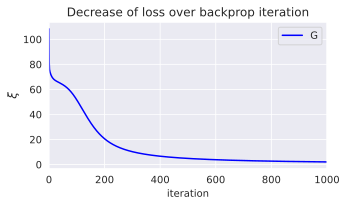

In [12]:
# Plot the loss over the iterations
fig = plt.figure(figsize=(5, 3))
plt.plot(ls_loss_gd, 'b-')
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=12)
plt.title('Decrease of loss over backprop iteration')
plt.xlim(0, epochs)
fig.subplots_adjust(bottom=0.2)
plt.legend('Gradient descent')
plt.show()
#

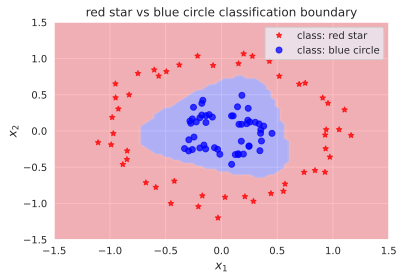

In [13]:
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 100
xs1 = np.linspace(-2, 2, num=nb_of_xs)
xs2 = np.linspace(-2, 2, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = nn_predict(
            np.asarray([xx[i,j], yy[i,j]]), Wh_f, bh_f, Wo_f, bo_f)
        classification_plane[i,j] = pred[0, 0]
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.25),
        colorConverter.to_rgba('r', alpha=0.25)])
plt.figure(figsize=(6, 4))
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 
         'r*', label='class: red star', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 
         'bo', label='class: blue circle', alpha=0.75)
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red star vs blue circle classification boundary')
plt.show()
#

# Momentum

In [14]:
def update_momentum(X, T, ls_of_params, Ms, momentum_term, 
                    learning_rate):
    """Update the momentum term."""
    # ls_of_params = [Wh, bh, Wo, bo]
    # Js = [JWh, Jbh, JWo, Jbo]
    Js = backprop_gradients(X, T, *ls_of_params)
    return [momentum_term * M - learning_rate * J 
            for M,J in zip(Ms, Js)]

def update_params(ls_of_params, Ms):
    """Update the parameters."""
    # ls_of_params = [Wh, bh, Wo, bo]
    # Ms = [MWh, Mbh, MWo, Mbo]
    return [P + M for P,M in zip(ls_of_params, Ms)]

In [15]:
# Run backpropagation
# Initialize weights and biases
init_var = .1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var
# Parameters are already initilized randomly with the gradient checking
# Set the learning rate
learning_rate = 0.02
momentum_term = 0.9

# Moments Ms = [MWh, Mbh, MWo, Mbo]
Ms = [np.zeros_like(M) for M in [Wh, bh, Wo, bo]]
Wh_iter, bh_iter, Wo_iter, bo_iter= Wh, bh, Wo, bo

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 1000  # number of gradient descent updates
# learning rate update rule
lr_update = learning_rate / nb_of_iterations
# list of loss over the iterations
ls_loss_mom = [loss(nn(X, Wh_iter, bh_iter, Wo_iter, bo_iter), T)]
for i in range(nb_of_iterations):
    # Update the moments and the parameters
    Ms = update_momentum(
        X, T, [Wh_iter, bh_iter, Wo_iter, bo_iter], Ms, momentum_term, learning_rate)
    Wh_iter, bh_iter, Wo_iter, bo_iter = update_params([Wh_iter, bh_iter, Wo_iter, bo_iter], Ms)
    ls_loss_mom.append(loss(nn(X, Wh_iter, bh_iter, Wo_iter, bo_iter), T))
Wh_f, bh_f, Wo_f, bo_f = Wh_iter, bh_iter, Wo_iter, bo_iter

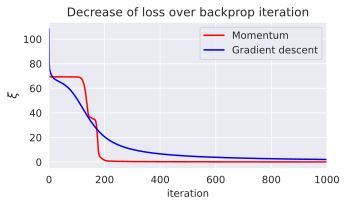

In [16]:
# Plot the loss over the iterations
fig = plt.figure(figsize=(5, 3))
plt.plot(ls_loss_mom, 'r-')
plt.plot(ls_loss_gd, 'b-')
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=12)
plt.title('Decrease of loss over backprop iteration')
plt.xlim(0, nb_of_iterations)
fig.subplots_adjust(bottom=0.2)
plt.legend(('Momentum','Gradient descent'))
plt.show()
#

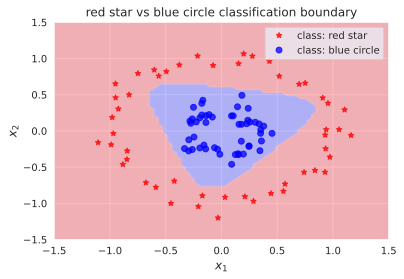

In [17]:
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 100
xs1 = np.linspace(-2, 2, num=nb_of_xs)
xs2 = np.linspace(-2, 2, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = nn_predict(
            np.asarray([xx[i,j], yy[i,j]]), Wh_f, bh_f, Wo_f, bo_f)
        classification_plane[i,j] = pred[0, 0]
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.25),
        colorConverter.to_rgba('r', alpha=0.25)])
plt.figure(figsize=(6, 4))
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 
         'r*', label='class: red star', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 
         'bo', label='class: blue circle', alpha=0.75)
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red star vs blue circle classification boundary')
plt.show()
#

## Visualization of the trained classifier
The resulting decision boundary of running backpropagation with momentum on the example inputs X and targets T is shown in the figure below. The background color (blue, red) refers to the classification decision of the trained classifier at that position in the input space. Note that the classifier is able to surround the blue circles and that all examples are classified correctly by the trained classifier

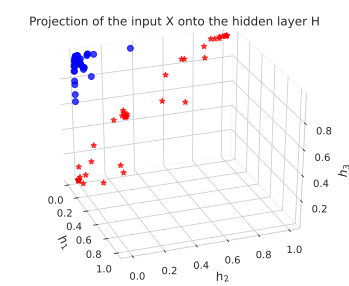

In [18]:
# Plot the projection of the input onto the hidden layer

# Define the projections of the blue and red classes
H_blue = hidden_activations(x_blue, Wh_f, bh_f)
H_red = hidden_activations(x_red, Wh_f, bh_f)
# Plot the error surface
fig = plt.figure(figsize=(6, 5))
with sns.axes_style("whitegrid"):
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.plot(
        np.ravel(H_blue[:,0]), np.ravel(H_blue[:,1]), np.ravel(H_blue[:,2]),
        'bo', label='class: blue circle', alpha=0.75)
    ax.plot(
        np.ravel(H_red[:,0]), np.ravel(H_red[:,1]), np.ravel(H_red[:,2]), 
        'r*', label='class: red star', alpha=0.75)
    ax.set_xlabel('$h_1$', fontsize=12)
    ax.set_ylabel('$h_2$', fontsize=12)
    ax.set_zlabel('$h_3$', fontsize=12)
    ax.view_init(elev=30, azim=-20)
    ax.set_title('Projection of the input X onto the hidden layer H', y=0.99)
plt.show()
#